# Initial analysis of the Kaggle dataset

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import openai
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

* Nodes = tweets
* Edges = similarity between tweets based on meaning (embedding cosine similarity)

### Load the dataset and generate the network

In [2]:
df = pd.read_csv("/Users/ame/02805_climate_conv/data/twitter_sentiment_data.csv",
                 encoding="latin1",
                 on_bad_lines="skip")

df["message"] = df["message"].astype(str)

df = df[df["message"].str.strip().replace("nan", np.nan).notna()]

def clean_text(msg):
    msg = msg.lower()
    msg = re.sub(r"http\S+", "", msg)       # remove URLs
    msg = re.sub(r"rt\s*@\w+:", "", msg)    # remove RT prefix
    msg = re.sub(r"@\w+", "", msg)          # remove mentions
    msg = re.sub(r"#", "", msg)             # remove hashtags
    msg = re.sub(r"[^a-z0-9\s]", " ", msg)  # keep letters/numbers
    msg = re.sub(r"\s+", " ", msg).strip()
    return msg

df["clean_text"] = df["message"].apply(clean_text)

df = df[df["clean_text"].str.len() > 0]

def is_valid_unicode(x):
    try:
        x.encode("utf-8")
        return True
    except:
        return False

df = df[df["clean_text"].apply(is_valid_unicode)]

df = df[df["clean_text"].str.len() <= 8000]

df = df.reset_index(drop=True)

print("Final cleaned dataset:", df.shape)

Final cleaned dataset: (43918, 4)


### No need to run again

In [ ]:
# Build nearest-neighbor search over embeddings

EMBEDDINGS_PATH = "/Users/ame/02805_climate_conv/data/tweet_embeddings.npy"

embeddings = np.load(EMBEDDINGS_PATH)

print("Building nearest-neighbor index...")

k = 50  # number of neighbors

nn = NearestNeighbors(n_neighbors=k, metric="cosine")
nn.fit(embeddings)

distances, indices = nn.kneighbors(embeddings)

# Cosine similarity = 1 - cosine distance
similarities = 1 - distances

In [ ]:
THRESHOLD = 0.60
G = nx.Graph()

# Make sure tweetid matches node IDs (usually strings)
df["tweetid"] = df["tweetid"].astype(str)

# ---- 1) ADD NODES FIRST ----
for _, row in df.iterrows():
    tid = row["tweetid"]
    G.add_node(
        tid,
        tweetid=tid,
        sentiment=row["sentiment"],   # numeric
        message=row["message"],
        clean_text=row["clean_text"],
    )

# ---- 2) MAP NUMERIC SENTIMENT → LABEL ----
sentiment_map = {
    2: "news",
    1: "pro",
    0: "neutral",
    -1: "anti",
}

df["sentiment_label"] = df["sentiment"].map(sentiment_map)

# Build dict: tweetid → label
label_attr = df.set_index("tweetid")["sentiment_label"].to_dict()

# ---- 3) NOW ADD LABELS TO EXISTING NODES ----
nx.set_node_attributes(G, label_attr, "sentiment_label")

# ---- 4) ADD EDGES ----
edges_added = 0
print("Building network with similarity threshold =", THRESHOLD)

for i in range(len(df)):
    for j_idx, sim in zip(indices[i], similarities[i]):
        if sim >= THRESHOLD and i != j_idx:
            tid1 = df.loc[i, "tweetid"]
            tid2 = df.loc[j_idx, "tweetid"]
            G.add_edge(tid1, tid2, weight=float(sim))
            edges_added += 1


print("Network created.")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

nx.write_gexf(G, "/Users/ame/02805_climate_conv/networks/climate_tweet_network.gexf")
print("Graph saved to networks")

### Desciption of the network

In [4]:
# Load network from file to G
G = nx.read_gexf("/Users/ame/02805_climate_conv/networks/climate_tweet_network.gexf")
print("Graph loaded from file")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Graph loaded from file
Nodes: 43918
Edges: 819673


In [5]:
# Print average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 37.327428389270914


In [6]:
# Max and min degree
degrees = dict(G.degree()).values()
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))

Max degree: 1590
Min degree: 0


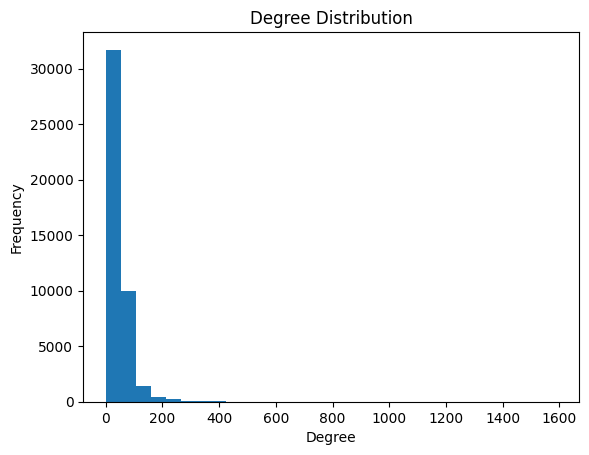

In [7]:
# Histogram of degree distribution
import matplotlib.pyplot as plt

plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Print number of nodes with 0 edges
num_isolated = sum(1 for node in G.nodes() if G.degree(node) == 0)
print("Number of nodes with 0 edges:", num_isolated)

Number of nodes with 0 edges: 3780


## Backboning and visualization

In [9]:
Gcc_nodes = max(nx.connected_components(G), key=len)
Gcc = G.subgraph(Gcc_nodes).copy()

# Approximate edge betweenness
# Choose sample size k (try 100 first)
k = 50

ebc = nx.edge_betweenness_centrality(Gcc, k=k, seed=42)

# Normalize betweenness to [1, 100]
vals = np.array(list(ebc.values()))
min_b, max_b = vals.min(), vals.max()

for u, v in Gcc.edges():
    w = ebc.get((u, v), 0.0)
    norm_w = 1 + 99 * (w - min_b) / (max_b - min_b) if max_b > min_b else 1
    Gcc[u][v]["weight"] = norm_w

W1 = Gcc.copy()

# Convert to DataFrame as before
W1_edges = [
    {"src": u, "trg": v, "nij": data["weight"]}
    for u, v, data in W1.edges(data=True)
]

table_W1 = pd.DataFrame(W1_edges)

In [10]:
import importlib
import backboning
importlib.reload(backboning)

<module 'backboning' from '/Users/ame/02805_climate_conv/backboning.py'>

In [11]:
df_W1 = backboning.disparity_filter(table_W1, undirected=True)
backbone_W1 = backboning.thresholding(df_W1, threshold=0.8)
G_backbone_W1 = nx.from_pandas_edgelist(
    backbone_W1, source="src", target="trg", edge_attr="score"
)

Calculating DF score...


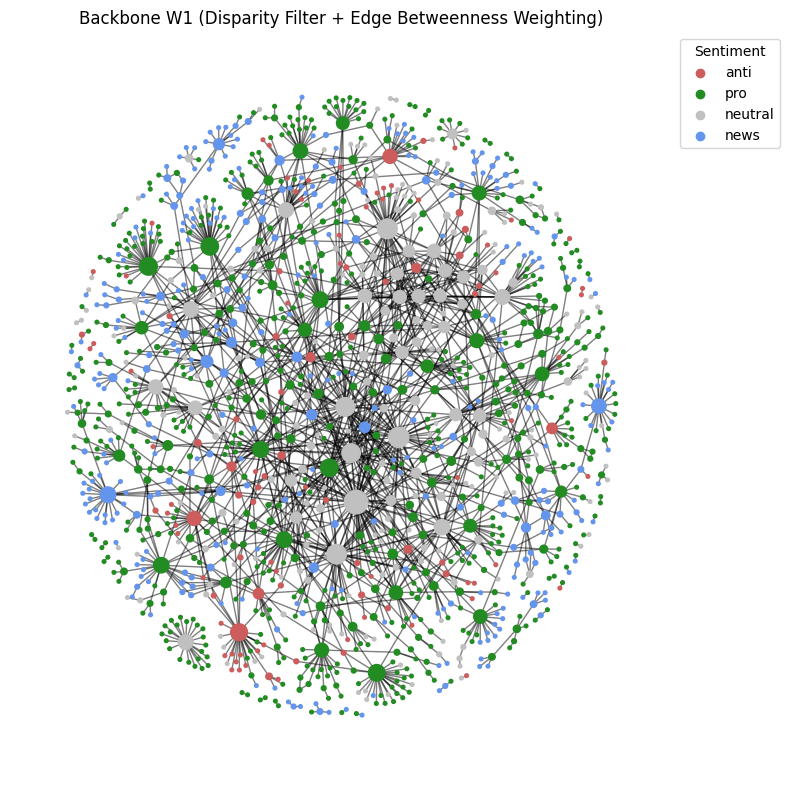

In [12]:
# Define colors
sentiment_colors = {
    "anti":      "indianred",  
    "pro":       "forestgreen",  
    "neutral":   "silver", 
    "news":      "cornflowerblue", 
}

# Make sure backbone nodes inherit sentiment from original G
for n in G_backbone_W1.nodes():
    if n in G.nodes:
        G_backbone_W1.nodes[n]["sentiment_label"] = G.nodes[n].get("sentiment_label")

# Layout ONLY for the backbone
pos_W1 = nx.forceatlas2_layout(
    G_backbone_W1,
    max_iter=500,
    gravity=0.8,
    scaling_ratio=2.0,
    seed=123,
    distributed_action=False,
    strong_gravity=True,
)

# Plot with sentiment-based coloring
fig, ax = plt.subplots(figsize=(8, 8))

# node sizes (degree-based)
node_sizes = [2 + G_backbone_W1.degree(n) * 5 for n in G_backbone_W1.nodes()]

nx.draw_networkx_edges(G_backbone_W1, pos_W1, ax=ax, alpha=0.5)

nodes = nx.draw_networkx_nodes(
    G_backbone_W1,
    pos_W1,
    ax=ax,
    node_size=node_sizes,
    alpha=1,
    node_color=[
        sentiment_colors.get(
            G_backbone_W1.nodes[n].get("sentiment_label"),
            "#7f7f7f"  # default grey if missing
        )
        for n in G_backbone_W1.nodes()
    ],
)

# Legend
for sentiment, color in sentiment_colors.items():
    ax.scatter([], [], c=color, label=sentiment)

ax.legend(
    title="Sentiment",
    loc="upper left",
    bbox_to_anchor=(1, 1),
)

ax.set_axis_off()
ax.set_title("Backbone W1 (Disparity Filter + Edge Betweenness Weighting)")
plt.tight_layout()
plt.show()

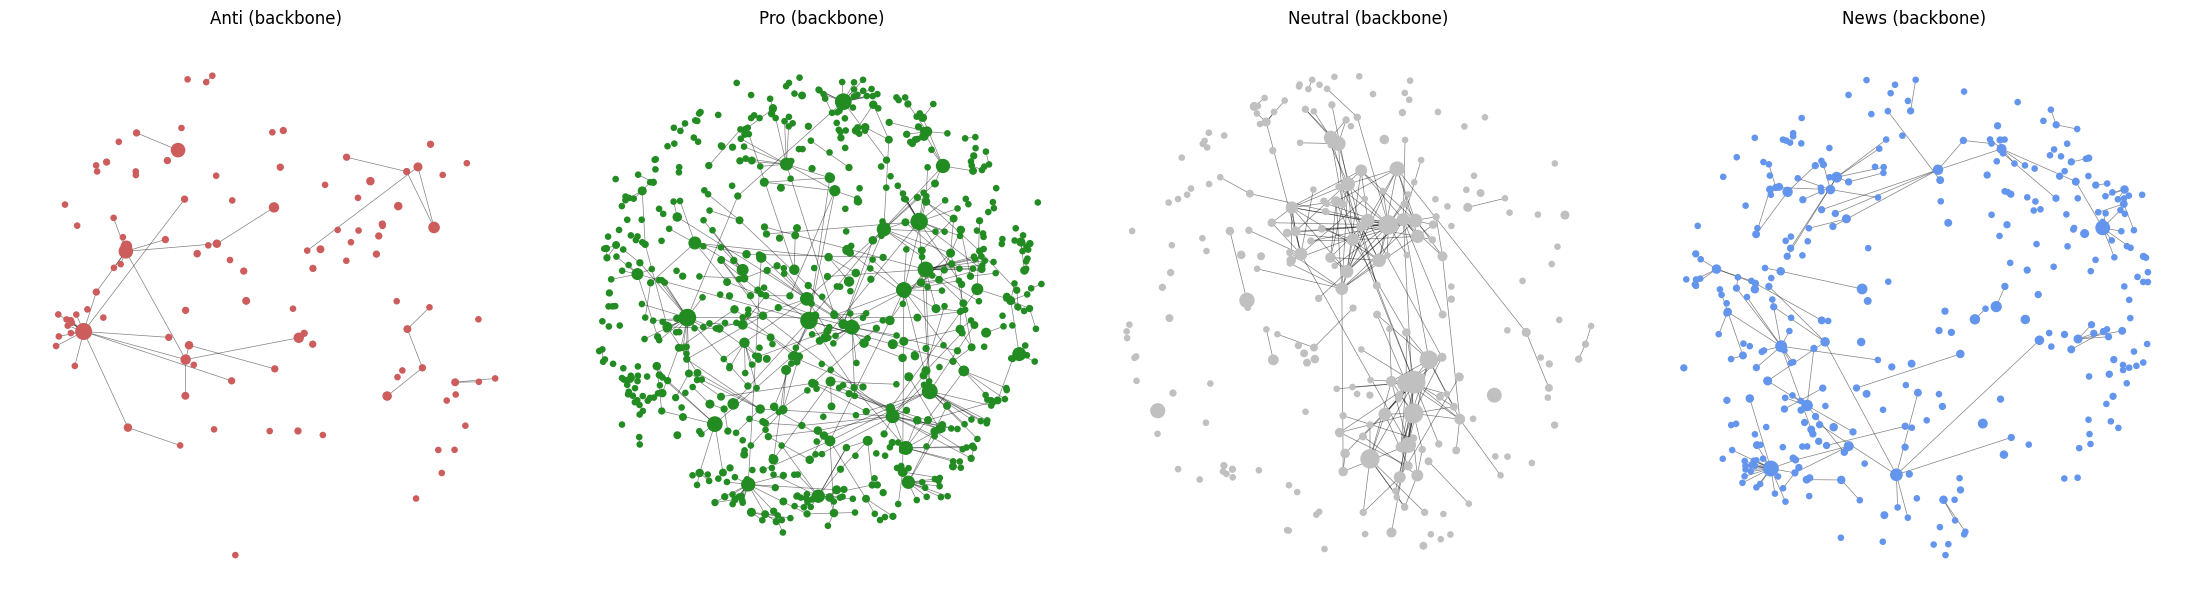

In [13]:
sentiments = ["anti", "pro", "neutral", "news"]

# 1. Compute a GLOBAL layout on the full backbone
pos_global = nx.forceatlas2_layout(
    G_backbone_W1,
    max_iter=800,
    gravity=0.8,
    scaling_ratio=2.0,
    seed=42,
    distributed_action=False,
    strong_gravity=True
)

# 2. Build sentiment-specific backbone subnetworks
subgraphs_backbone = {
    s: G_backbone_W1.subgraph([
        n for n in G_backbone_W1.nodes()
        if G.nodes[n].get("sentiment_label") == s
    ]).copy()
    for s in sentiments
}

# 3. Plot using SAME POSITIONS
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, sentiment in zip(axes, sentiments):

    SG = subgraphs_backbone[sentiment]

    # degree sizes (within backbone)
    deg = dict(G_backbone_W1.degree())
    node_sizes = [10 + 4 * deg[n] for n in SG.nodes()]

    # edges and nodes
    nx.draw_networkx_edges(
        SG, pos_global, ax=ax,
        width=0.5, alpha=0.5
    )
    nx.draw_networkx_nodes(
        SG, pos_global, ax=ax,
        node_color=sentiment_colors[sentiment],
        node_size=node_sizes,
        alpha=1
    )

    ax.set_title(f"{sentiment.capitalize()} (backbone)")
    ax.set_axis_off()

plt.tight_layout()
plt.show()


## Detect emotions

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

MODEL = "cardiffnlp/twitter-roberta-base-emotion"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# model returns logits for these labels:
EMOTION_LABELS = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

In [15]:
def get_emotion(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None, None

    # tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    # get model output
    with torch.no_grad():
        logits = model(**inputs).logits

    # softmax for probabilities
    probs = torch.softmax(logits, dim=1).numpy()[0]

    # get top emotion
    top_idx = np.argmax(probs)
    top_emotion = EMOTION_LABELS[top_idx]

    return top_emotion, dict(zip(EMOTION_LABELS, probs))

In [21]:
print("Example node:", next(iter(G.nodes())))
print("Node type:", type(next(iter(G.nodes()))))

print("Example df tweetid:", df["tweetid"].iloc[0])
print("df tweetid type:", df["tweetid"].iloc[0].__class__)

Example node: 792927353886371840
Node type: <class 'str'>
Example df tweetid: 792927353886371840
df tweetid type: <class 'numpy.int64'>


In [22]:
top_nodes_by_sentiment = {}

for category in ["pro", "anti", "news", "neutral"]:
    # Filter nodes in this sentiment group
    nodes_in_group = [
        n for n in G.nodes()
        if G.nodes[n].get("sentiment_label") == category
    ]

    # Sort these nodes by degree
    top_nodes = sorted(
        nodes_in_group,
        key=lambda n: deg.get(n, 0),
        reverse=True
    )[:1000]

    top_nodes_by_sentiment[category] = top_nodes

selected_nodes = (
    top_nodes_by_sentiment["pro"] +
    top_nodes_by_sentiment["anti"] +
    top_nodes_by_sentiment["news"] +
    top_nodes_by_sentiment["neutral"]
)

# Convert tweet IDs to string before matching
df_subset = df[df["tweetid"].astype(str).isin(selected_nodes)].copy()

print("Selected tweets:", len(df_subset))

emotions = []
emotion_probs = []

for row in df_subset.itertuples(index=False):
    emotion, prob_dict = get_emotion(row.clean_text)
    emotions.append(emotion)
    emotion_probs.append(prob_dict)

df_subset["emotion"] = emotions
df_subset["emotion_probs"] = emotion_probs


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Selected tweets: 4000


In [23]:
# Make sure tweetid matches node IDs (string)
df_subset["tweetid"] = df_subset["tweetid"].astype(str)

# Build mapping: tweetid -> emotion
emotion_attr = df_subset.set_index("tweetid")["emotion"].to_dict()

# Build mapping: tweetid -> emotion_probs (dict of 6 probs)
emotion_probs_attr = df_subset.set_index("tweetid")["emotion_probs"].to_dict()

# Attach as node attributes on G
nx.set_node_attributes(G, emotion_attr, "emotion")
nx.set_node_attributes(G, emotion_probs_attr, "emotion_probs")

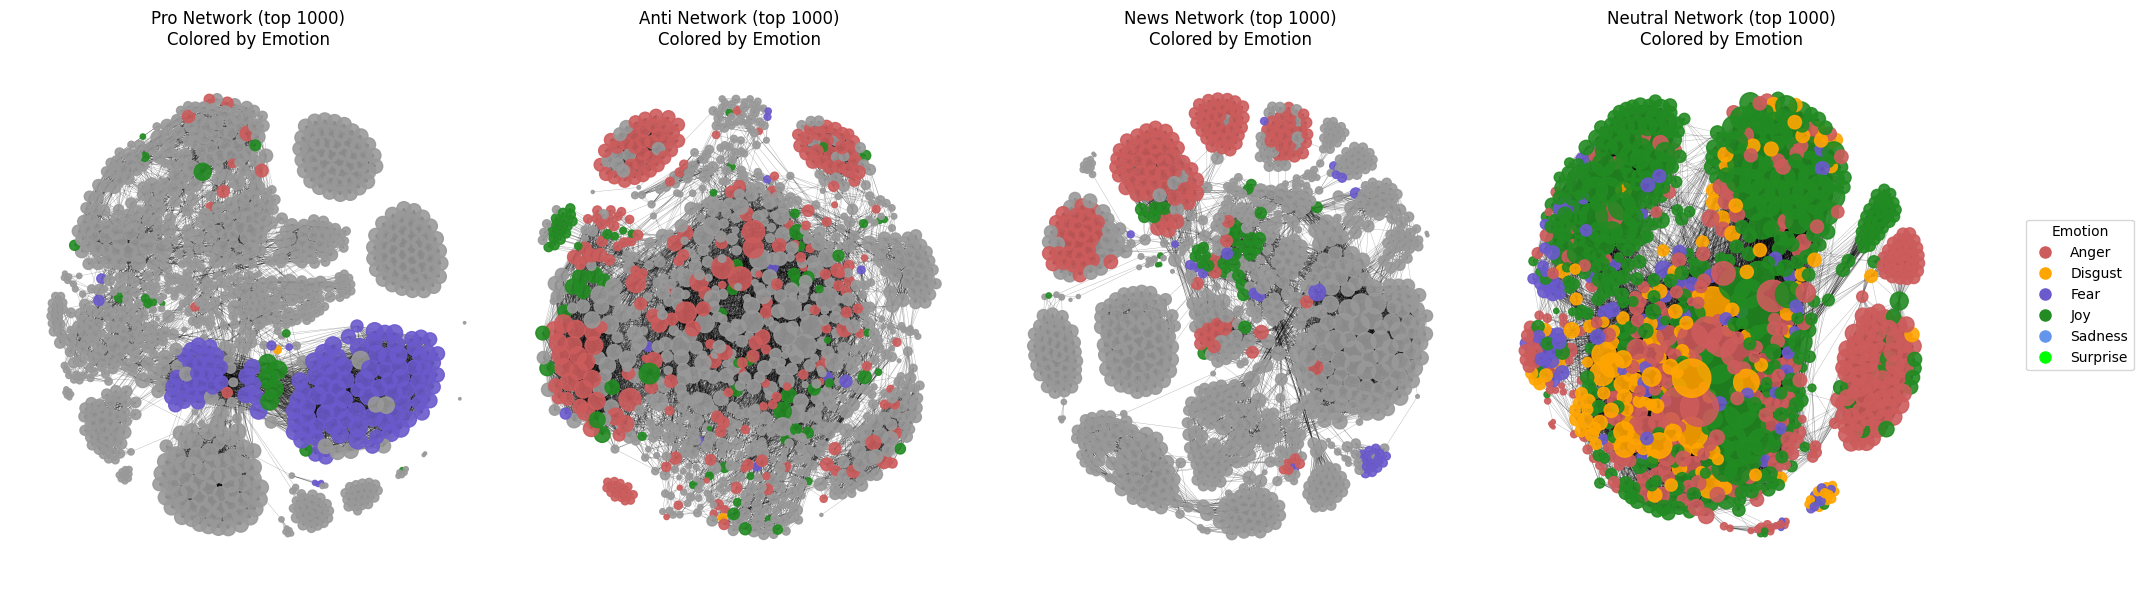

In [28]:
# ---- 1) Build four subnetworks based on sentiment_label ----
sentiments = ["pro", "anti", "news", "neutral"]

subgraphs = {
    s: G.subgraph([
        n for n in G.nodes()
        if G.nodes[n].get("sentiment_label") == s
    ]).copy()
    for s in sentiments
}

# ---- 2) Emotion colors ----
emotion_colors = {
    "anger":    "indianred",
    "disgust":  "orange",
    "fear":     "slateblue",
    "joy":      "forestgreen",
    "sadness":  "cornflowerblue",
    "surprise": "lime",
}

# ---- 3) Plot the four networks next to each other ----
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, sentiment in zip(axes, sentiments):
    SG_full = subgraphs[sentiment]

    if SG_full.number_of_nodes() == 0:
        ax.set_title(f"{sentiment.capitalize()} Network (no nodes)")
        ax.set_axis_off()
        continue

    # Top 1000 nodes by degree (within this sentiment group)
    deg_full = dict(SG_full.degree())
    top_nodes = sorted(deg_full, key=deg_full.get, reverse=True)[:1000]
    SG = SG_full.subgraph(top_nodes).copy()

    # Layout
    pos = nx.forceatlas2_layout(
        SG,
        seed=42,
        max_iter=1000,
        distributed_action=False,
        strong_gravity=True
    )

    # Node sizes
    deg = dict(SG.degree())
    node_sizes = [3 + 2 * deg[n] for n in SG.nodes()]

    # Node colors based on EMOTION
    node_colors = [
        emotion_colors.get(G.nodes[n].get("emotion"), "#999999")
        for n in SG.nodes()
    ]

    # Draw network
    nx.draw_networkx_edges(SG, pos, ax=ax, width=0.3, alpha=0.3)
    nx.draw_networkx_nodes(
        SG,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9
    )

    ax.set_title(f"{sentiment.capitalize()} Network (top 1000)\nColored by Emotion")
    ax.set_axis_off()

# ---- 4) Add one shared legend on the right ----
legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=8,
        color=color,
        label=emotion.capitalize()
    )
    for emotion, color in emotion_colors.items()
]

# Make room on the right for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])

fig.legend(
    handles=legend_handles,
    title="Emotion",
    loc="center left",
    bbox_to_anchor=(0.92, 0.5)
)

plt.show()


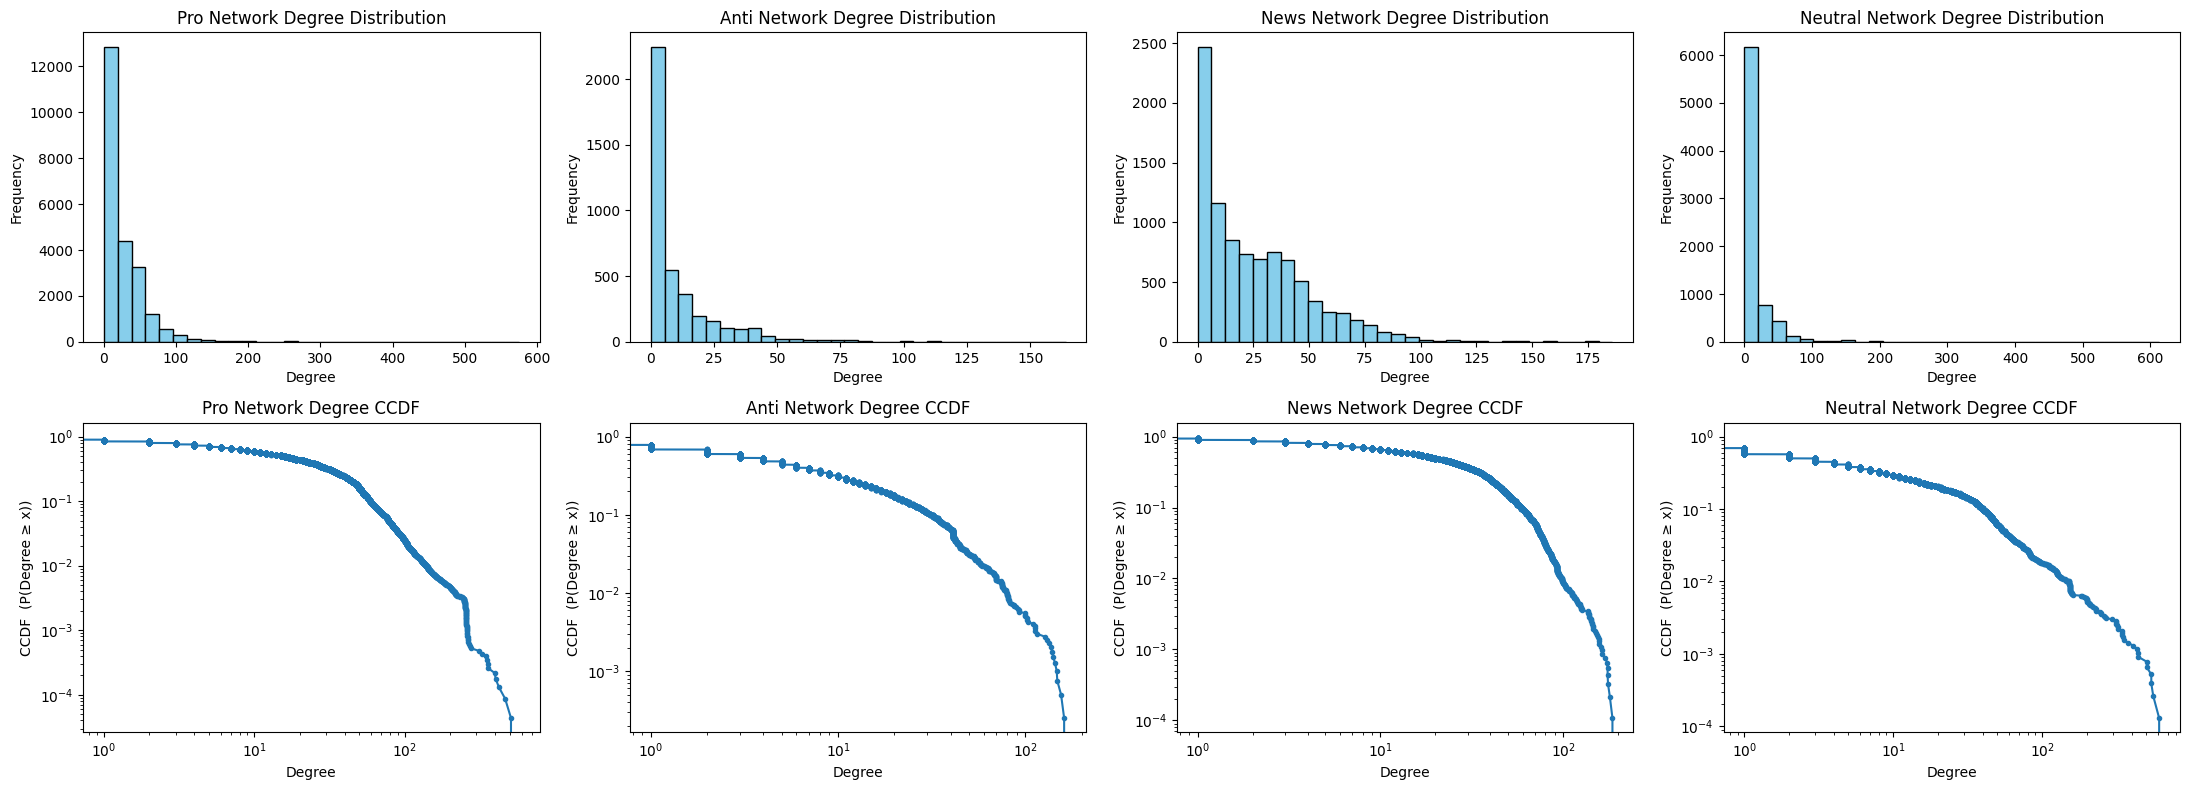

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def compute_ccdf(data):
    data = np.array(data)
    data = np.sort(data)
    n = len(data)
    # CCDF: P(X ≥ x)
    ccdf = 1.0 - np.arange(1, n + 1) / n
    return data, ccdf

# Plot: top row = histograms, bottom row = CCDFs
fig, axes = plt.subplots(2, 4, figsize=(22, 8))

for col, sentiment in enumerate(sentiments):
    SG = subgraphs[sentiment]

    if SG.number_of_nodes() == 0:
        axes[0, col].set_title(f"{sentiment.capitalize()} Network (no nodes)")
        axes[0, col].set_axis_off()
        axes[1, col].set_axis_off()
        continue

    degrees = [d for _, d in SG.degree()]

    # --- Top row: histogram ---
    ax_hist = axes[0, col]
    ax_hist.hist(degrees, bins=30, color="skyblue", edgecolor="black")
    ax_hist.set_title(f"{sentiment.capitalize()} Network Degree Distribution")
    ax_hist.set_xlabel("Degree")
    ax_hist.set_ylabel("Frequency")

    # --- Bottom row: CCDF ---
    ax_ccdf = axes[1, col]
    x, y = compute_ccdf(degrees)
    ax_ccdf.plot(x, y, marker=".", linestyle="-")
    ax_ccdf.set_xlabel("Degree")
    ax_ccdf.set_ylabel("CCDF  (P(Degree ≥ x))")
    ax_ccdf.set_title(f"{sentiment.capitalize()} Network Degree CCDF")

    # Optional: use log scale if you like (often helpful for degree)
    ax_ccdf.set_xscale("log")
    ax_ccdf.set_yscale("log")

plt.tight_layout()
plt.show()
